## 2 Layer MLP
- With hidden layer of size 64 and dropout with 0.5 probability
- Softmax at last classification layer 
- Learning rate of 0.001
- Over 50-100 epochs

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model




encoder = load_model("../Models/AE/encoder_h5_wmse_200.keras")
X = np.load("../Data/LPS/classifier_lps_data.npy")
Y = np.load("../Data/LPS/classifier_lps_labels.npy")
print("NaN in training data:", np.isnan(X).any())
print("Input range:", np.min(X), "to", np.max(X))
print(X.shape)


2025-10-31 18:38:51.436266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-31 18:38:56.237604: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-10-31 18:38:56.254732: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 539992000 exceeds 10% of free system memory.
2025-10-31 18:38:56.355706: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 539992000 exceeds 10% of free system memory.
2025-10-31 18:38:56.428222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 539992000 exceeds 10% of free system memory.
2025-10-31 18:38:57.414962: W external/local_xla/

NaN in training data: False
Input range: 0.0 to 0.9999899
(3315, 67499)


In [2]:
X = encoder(X)
print(X.shape)
del encoder

2025-10-31 18:38:58.263348: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 895036740 exceeds 10% of free system memory.


(3315, 200)


In [3]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True
)

In [4]:
class MLPClassifier(tf.keras.Model):
    def __init__(self, hidden_size=200, dropout_rate=0.5, num_classes=2):
        super().__init__()
        # Add activation function to hidden layer
        self.hidden_layer = layers.Dense(hidden_size, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.output_layer = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):  # Set default to False
        x = self.hidden_layer(inputs)
        # Only apply dropout during training
        if training:
            x = self.dropout(x)
        return self.output_layer(x)

In [5]:
# Split into train (60%), temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X.numpy(), Y, test_size=0.3, random_state=42, stratify=Y)
# Split temp into val (50% of temp = 20% total) and test (50% of temp = 20% total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42, stratify=y_temp)
del X, X_temp, y_temp

In [6]:
print(f'Training data shape: {X_train.shape}')
print(f'Val data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')


Training data shape: (2320, 200)
Val data shape: (328, 200)
Test data shape: (667, 200)


In [7]:
print("NaN in training data:", np.isnan(X_train).any())
print("Input range:", np.min(X_train), "to", np.max(X_train))

NaN in training data: False
Input range: -0.6479749 to 0.57202715


In [8]:
# for layer in encoder.layers:
#     layer.trainable = True
model = MLPClassifier(hidden_size=64, dropout_rate=0.5)
# model = load_model("../models.keras")

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=10,
    restore_best_weights=True
)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Important!
              metrics=['accuracy'],
            )

print("Training started....")
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,    
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[early_stopping,
            #    WandbMetricsLogger(),
            #    WandbModelCheckpoint("models.keras",save_best_only=True,monitor='accuracy')
               ]
)
# wandb.finish()
print("Training completed!")


Training started....
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5664 - loss: 0.6796 - val_accuracy: 0.6341 - val_loss: 0.6643
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6030 - loss: 0.6621 - val_accuracy: 0.6433 - val_loss: 0.6517
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.6368 - val_accuracy: 0.6402 - val_loss: 0.6282
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6565 - loss: 0.6233 - val_accuracy: 0.7073 - val_loss: 0.6108
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6828 - loss: 0.6083 - val_accuracy: 0.7165 - val_loss: 0.5906
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6871 - loss: 0.5941 - val_accuracy: 0.7165 - val_loss: 0.5774
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6953 - loss: 0.5821 - val_accuracy: 0.7287 - val_loss: 0.5633
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7147 - loss: 0.5690 - val_accurac

In [9]:
model.summary()

Model: "mlp_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,983 (152.28 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,989 (101.52 KB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7976 - loss: 0.4541 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
TN: 262, FP: 72, FN: 63, TP: 270
AUC: 0.8733568898239559


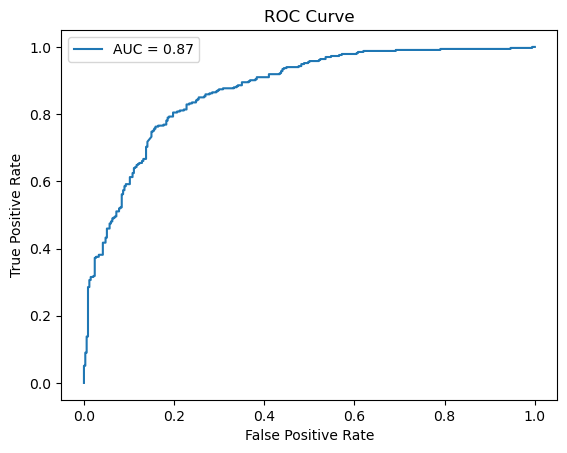

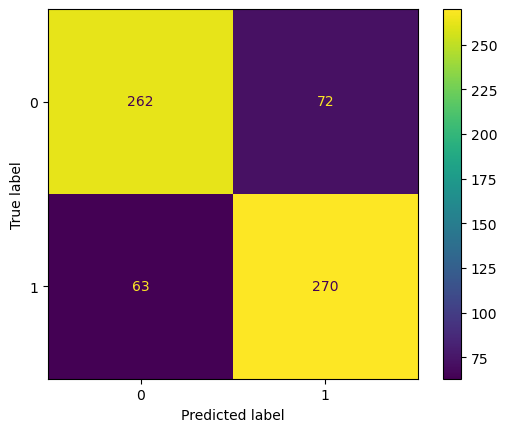

Test loss: 0.4541468918323517
Test Accuracy 0.7976012229919434
Precision: 0.7895
Recall (Sensitivity/TPR): 0.8108
Specificity (TNR): 0.7844
F1-Score: 0.8000
False Positive Rate (FPR): 0.2156
False Negative Rate (FNR): 0.1892
Negative Predictive Value (NPV): 0.8062


In [10]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
loss, accuracy = model.evaluate(X_test, y_test)

y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')

if len(np.unique(y_test)) == 2:
    auc = roc_auc_score(y_test, y_pred_probs[:, 1])
    print(f'AUC: {auc}')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])

    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(f'Test loss: {loss}')
print(f'Test Accuracy {accuracy}')
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
true_positive_rate = tp / (tp + fn)  # Same as recall/sensitivity
negative_predictive_value = tn / (tn + fn)

print(f'Precision: {precision:.4f}')
print(f'Recall (Sensitivity/TPR): {recall:.4f}')
print(f'Specificity (TNR): {specificity:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'False Positive Rate (FPR): {false_positive_rate:.4f}')
print(f'False Negative Rate (FNR): {false_negative_rate:.4f}')
print(f'Negative Predictive Value (NPV): {negative_predictive_value:.4f}')

In [11]:
# model.encoder.save("../Models/Decoder/encoder_classifier.keras")
# model.classifier.save("../Models/Decoder/classifier.keras")
